In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.tri import Triangulation
def triangulation_for_triheatmap(M, N):
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)
    zs = (xs * ys) % 10
    zs = zs[:-1, :-1].ravel()

    triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
    return [triang1, triang2]

In [3]:
#### data
# Load the arrays from the npz file
data = np.load('.\Interresult\heatmap_solar_summer.npz')

m_joint = data ['m_joint'][:, 1::2]
m_disjoint = data ['m_disjoint'][:, 1::2]
m_single = data ['m_single'][:, 1::2]
m_joint_noArb = data ['m_joint_noArb'][:, 1::2]
valueWind = data ['valueWind'][:, 1::2]
valueWind_noArb = data ['valueWind_noArb'][:, 1::2]
value_arbitrager = data ['value_arbitrager'][:, 1::2]
print(value_arbitrager.shape)

(9, 4)


In [4]:
storage_choice = np.arange(0.2, 2, 0.2)*1000
storage_choice=storage_choice.astype(int)
RES_choice = np.arange(0.4, 2, 0.4)*1000
RES_choice =RES_choice.astype(int)
value_df = pd.DataFrame({'Storage Capacity (MW)': np.repeat(storage_choice, len(RES_choice)),
                   'Solar Capacity (MW)': np.tile(RES_choice, len(storage_choice))})
valueWind = np.round(valueWind*1000, decimals=2)
valueWind_noArb = np.round(valueWind_noArb*1000, decimals=1)
value_arbitrager = np.round(value_arbitrager*1000, decimals=1)
# value_df['RES'] = valueWind.flatten()
# value_df['arbitrager'] = value_arbitrager.flatten()
gap_1 = (-valueWind+value_arbitrager)
gap_2 = (-valueWind_noArb+value_arbitrager)
value_df['Gap (Arbitrager - RES)'] = (gap_1).flatten()
value_df['Gap (Arbitrager) - RES(mono)'] = (gap_2).flatten()
value_df.head()

,Storage Capacity (MW),Solar Capacity (MW),Gap (Arbitrager - RES),Gap (Arbitrager) - RES(mono)
0,200,400,116.68,1147.6
1,200,800,193.54,1171.3
2,200,1200,201.91,1135.4
3,200,1600,178.47,1101.8
4,400,400,235.19,2313.9


In [5]:
df_piv = value_df.pivot_table(index='Solar Capacity (MW)', columns='Storage Capacity (MW)')
df_piv.head()


Gap (Arbitrager - RES)                            \
Storage Capacity (MW)                   200     400      600      800    
Solar Capacity (MW)                                                      
400                                   116.68  235.19   351.37   466.18   
800                                   193.54  430.52   661.50   891.17   
1200                                  201.91  556.89   901.89  1246.27   
1600                                  178.47  619.28  1053.48  1457.20   

                                                                    \
Storage Capacity (MW)     1000     1200     1400     1600     1800   
Solar Capacity (MW)                                                  
400                     582.29   699.75   817.27   934.75  1052.32   
800                    1122.02  1357.08  1590.85  1809.35  2008.38   
1200                   1574.52  1882.87  2175.83  2450.16  2710.72   
1600                   1830.61  2181.84  2519.12  2856.47  3198.10   

                      Gap (Arbitrager) - RES(mono)                          \
Storage Capacity (MW)                         200     400     600     800    
Solar Capacity (MW)                                                          
400                                         1147.6  2313.9  3506.0  4773.6   
800                                         1171.3  2397.4  3624.3  4860.6   
1200                                        1135.4  2425.6  3713.9  4954.7   
1600                                        1101.8  2370.5  3630.0  4832.7   

                                                                
Storage Capacity (MW)    1000    1200    1400    1600     1800  
Solar Capacity (MW)                                             
400                    6009.3  7230.2  8418.3  9606.9  10773.9  
800                    6079.1  7254.0  8390.5  9488.3  10546.7  
1200                   6135.7  7267.4  8358.2  9408.9  10426.1  
1600                   5975.1  7065.8  8116.9  9143.1  10148.7

In [6]:
M = len(df_piv.columns)//2
N = len(df_piv)
print(M,N)
values = [df_piv[dir] for dir in
          ['Gap (Arbitrager - RES)', 'Gap (Arbitrager) - RES(mono)']]  
triangul = triangulation_for_triheatmap(M, N)


9 4


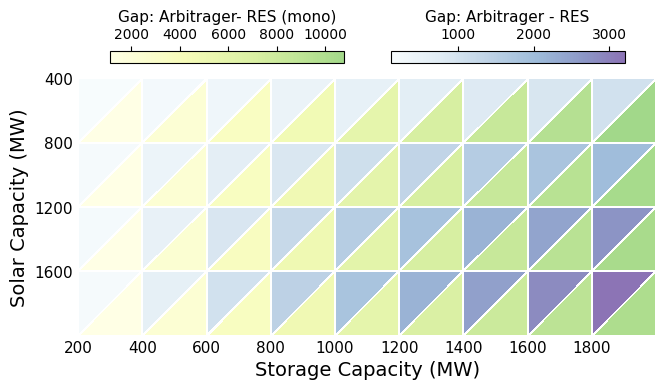

In [7]:
import matplotlib.colors as mcolors
cmap_1 = plt.cm.YlGn
# Define the range of colors you want to extract
# start_color = 0  # Start position in the colormap (between 0 and 1)
# end_color = 0.6  # End position in the colormap (between 0 and 1)
# Create a segmented colormap with the desired range of colors
segmented_cmap1 = mcolors.ListedColormap(cmap_1(np.linspace(0, 0.4, 256)))
cmap_2 = plt.cm.BuPu
segmented_cmap2 = mcolors.ListedColormap(cmap_2(np.linspace(0, 0.6, 256)))
cmaps = [segmented_cmap2, segmented_cmap1]
norms = [plt.Normalize(np.min(gap_1), np.max(gap_1))]+ [plt.Normalize(np.min(gap_2), np.max(gap_2))]
fig, ax = plt.subplots(figsize=(12, 4))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]
ax.set_frame_on(False)
ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(df_piv['Gap (Arbitrager) - RES(mono)'].columns)
ax.set_yticks(range(N))
ax.set_yticklabels(df_piv.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells

# axins = inset_axes(plt.gca(),width="100%",  height="5%",loc='lower right', borderpad=2.3)

cbar_3 = plt.colorbar(imgs[1], ax=ax, location='top', shrink=0.2, pad = -0.15, anchor = (0.35,0.0))
cbar_3.set_label('Gap: Arbitrager- RES (mono)', fontsize = 11)
cbar_2 = plt.colorbar(imgs[0], ax=ax, location='top', shrink=0.2, anchor = (0.65,0.0))
cbar_2.set_label('Gap: Arbitrager - RES', fontsize = 11)
cbar_2.ax.set_position(cbar_3.ax.get_position())
cbar_2.ax.tick_params(labelsize=10)  # Set the desired font size
cbar_3.ax.tick_params(labelsize=10)  # Set the desired font size
plt.xlabel('Storage Capacity (MW)', fontsize = 14)
plt.ylabel('Solar Capacity (MW)', fontsize = 14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig(".\pics\heatmap_GAP_solar_summer.pdf", bbox_inches='tight')
plt.show()